In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn import svm


Bad key "text.kerning_factor" on line 4 in
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
datasetName = 'PAMAP2' # PAMAP2 or HAR-UML20
EXP_NAME = 'frequency_viz'
FEATURE_SIZE = 32
# CLASS_LABELS = ['Sedentary', 'Light', 'Moderate', 'Vigorous']
UMAP_NEIGHTBORS = 20
N_EPOCHS = 4000
RESULTS_PATH = 'results'

In [3]:


if datasetName == 'PAMAP2':
    # signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3']
    signals=['heartrate']
    dataset = DatasetPAMAP2(seconds = 4 , mode = 'leave-one-subject')
    
elif datasetName ==  'HAR-UML20':
    signals = ['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z']
    dataset = DatasetHARUML20(mode = 'leave-one-subject')

    
CLASS_LABELS = dataset.activities
save_name = datasetName + '_' + EXP_NAME
saver = MetricsSaver(save_name, rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])

In [4]:
# dataset.y_train.shape

In [5]:
dataset.loadData()
dataset.filterSignals(signals)

# dataset.y_train[dataset.y_train == 1] = 0
# dataset.y_train[dataset.y_train == 2] = 0

# dataset.y_test[dataset.y_test == 1] = 0
# dataset.y_test[dataset.y_test == 2] = 0

In [6]:
ts_train = TSerie(dataset.X_train, dataset.Int_train, I=dataset.I_train)
ts_test = TSerie(dataset.X_test, dataset.Int_test, I=dataset.I_test)

# ts_train.center()
# ts_test.center()

In [7]:
from scipy.fft import fft

def smooth(x,window_len=11,window='hanning'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:  
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='same')
    return y[window_len:-window_len+1]



# ts_train.center()
# ts_test.center()

# ts_train.znorm()
# ts_test.znorm()

# # minv, maxv = ts_train.minMaxNormalization()
# # ts_test.minMaxNormalization( minl= minv,maxl= maxv)


ts_train.folding_features_v2()
ts_test.folding_features_v2()



# ts_train.features =  np.linalg.norm(ts_train.X[:, :, :3], axis=2)
# ts_test.features = np.linalg.norm(ts_test.X[:, :, :3], axis=2)

# for i in range(ts_train.N):
#     ts_train.features[i] = np.absolute(fft(ts_train.features[i]))
#     # ts_train.features[i] = fft(ts_train.features[i])
#     # ts_train.features[i] = smooth(ts_train.features[i], window_len=20)
#     # ts_train.features[i][ts_train.features[i] < 400] = 0
    
# for i in range(ts_test.N):
#     ts_test.features[i] = np.absolute(fft(ts_test.features[i]))
#     # ts_test.features[i] = smooth(ts_test.features[i], window_len=20)
#     # ts_test.features[i][ts_test.features[i] < 400] = 0
#     # ts_test.features[i] = fft(ts_test.features[i])

# # ts_train.features = ts_train.features[:, 1:ts_train.T//2 + 1]
# # ts_test.features = ts_test.features[:, 1:ts_train.T//2 + 1]
# ts_train.features[:, ts_train.T//2 + 1:]=0
# ts_test.features[:, ts_train.T//2 + 1:]=0

# ts_train.features[:, 0] = 0
# ts_test.features[:, 0] = 0


In [8]:
# model = UMAP_FL(n_components=32,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS, metric='euclidean')
# ts_train.features = model.fit_transform(ts_train.features)
# # train_coords = model.fit_transform(ts_train.features)
# ts_test.features = model.transform(ts_test.features)

In [9]:
projector = UMAP_FL(n_components=2, n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS, metric='euclidean',)
train_coords = projector.fit_transform(ts_train.features, y=ts_train.y)
# train_coords = model.fit_transform(ts_train.features)
test_coords = projector.transform(ts_test.features)

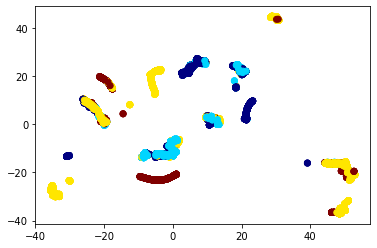

In [10]:
import matplotlib.pyplot as plt
# import seaborn as sns

plt.scatter(train_coords[:,0], train_coords[:,1], c=ts_train.y.flatten(), cmap='jet')
# plt.scatter(train_coords[:,0], train_coords[:,1], )

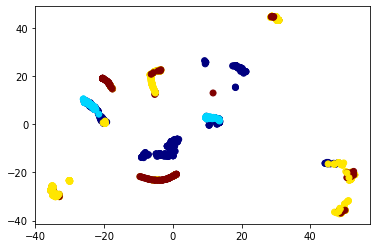

In [11]:
import matplotlib.pyplot as plt

plt.scatter(test_coords[:,0], test_coords[:,1], c=ts_test.y.flatten(), cmap='jet')

In [12]:
from sklearn import metrics

clf = svm.SVC()
clf.fit(ts_train.features, ts_train.y)
train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)


# Save metrics
train_f1 = metrics.f1_score(ts_train.y, train_pr, average='weighted')
test_f1 = metrics.f1_score(ts_test.y, test_pr, average='weighted')
train_bacc = metrics.balanced_accuracy_score(ts_train.y, train_pr)
test_bacc = metrics.balanced_accuracy_score(ts_test.y, test_pr)
train_acc = metrics.accuracy_score(ts_train.y, train_pr)
test_acc = metrics.accuracy_score(ts_test.y, test_pr)

print('Test f1_score: {}'.format(test_f1))
print('Test acc: {}'.format(test_acc))
print('Test bacc: {}'.format(test_bacc))


Test f1_score: 0.6030522504978334
Test acc: 0.6341463414634146
Test bacc: 0.5092187785466338


In [13]:
print(np.unique(ts_train.y))

[0. 1. 2. 3.]


In [14]:
from source.utils import accuracy_per_class
import warnings
warnings.filterwarnings('ignore')

clf = svm.SVC()

train_bin_y = np.copy(ts_train.y)
test_bin_y = np.copy(ts_test.y)

target_intensity = 0


train_bin_y[train_bin_y != target_intensity] = -1
test_bin_y[test_bin_y != target_intensity] = -1
train_bin_y[train_bin_y == target_intensity] = 1
test_bin_y[test_bin_y == target_intensity] = 1
train_bin_y[train_bin_y ==-1] = 0
test_bin_y[test_bin_y ==-1] = 0


accuracy_per_class(
    clf, 
    train_bin_y, test_bin_y, 
    ts_train.features, ts_test.features, 
    dataset.y_train, dataset.y_test, 
    dataset.activities_map
)


(array([1.]), array([133]))
(array([0., 1.]), array([75, 58]))
Class : lying
Test f1_score: 0.6073298429319371
Test acc: 0.43609022556390975
Test bacc: 0.43609022556390975
Test recall: 0.43609022556390975
Test precision: 1.0

(array([1.]), array([116]))
(array([0., 1.]), array([113,   3]))
Class : sitting
Test f1_score: 0.050420168067226885
Test acc: 0.02586206896551724
Test bacc: 0.02586206896551724
Test recall: 0.02586206896551724
Test precision: 1.0

(array([1.]), array([107]))
(array([0.]), array([107]))
Class : standing
Test f1_score: 0.0
Test acc: 0.0
Test bacc: 0.0
Test recall: 0.0
Test precision: 0.0

(array([0.]), array([110]))
(array([0.]), array([110]))
Class : walking
Test f1_score: 1.0
Test acc: 1.0
Test bacc: 1.0
Test recall: 0.0
Test precision: 0.0

(array([0.]), array([105]))
(array([0.]), array([105]))
Class : running
Test f1_score: 1.0
Test acc: 1.0
Test bacc: 1.0
Test recall: 0.0
Test precision: 0.0

(array([0.]), array([116]))
(array([0.]), array([116]))
Class : cyc

In [15]:
from sklearn import metrics

clf = svm.SVC()

train_bin_y = np.copy(ts_train.y)
test_bin_y = np.copy(ts_test.y)

target_intensity = 0


train_bin_y[train_bin_y != target_intensity] = -1
test_bin_y[test_bin_y != target_intensity] = -1
train_bin_y[train_bin_y == target_intensity] = 1
test_bin_y[test_bin_y == target_intensity] = 1
train_bin_y[train_bin_y ==-1] = 0
test_bin_y[test_bin_y ==-1] = 0


clf.fit(ts_train.features, train_bin_y)
train_bin_pr = clf.predict(ts_train.features)
test_bin_pr = clf.predict(ts_test.features)

# Save metrics
train_f1 = metrics.f1_score(train_bin_y, train_bin_pr, average='weighted')
test_f1 = metrics.f1_score(test_bin_y, test_bin_pr, average='weighted')
train_bacc = metrics.balanced_accuracy_score(train_bin_y, train_bin_pr)
test_bacc = metrics.balanced_accuracy_score(test_bin_y, test_bin_pr)
train_acc = metrics.accuracy_score(train_bin_y, train_bin_pr)
test_acc = metrics.accuracy_score(test_bin_y, test_bin_pr)

print('Test f1_score: {}'.format(test_f1))
print('Test acc: {}'.format(test_acc))
print('Test bacc: {}'.format(test_bacc))


Test f1_score: 0.6926437504056424
Test acc: 0.7601626016260162
Test bacc: 0.5856741573033708


In [16]:

# ts_train.X = np.concatenate([ts_train.X, np.expand_dims(ts_train.features, axis = 2)], axis =2)
# ts_test.X = np.concatenate([ts_test.X, np.expand_dims(ts_test.features, axis = 2)], axis =2)

In [17]:
# import sys
# sys.path.insert(0, '/home/texs/Documentos/Repositories/mts_viz')

from server.source.storage import MTSStorage

storage = MTSStorage('visualizations')
storage.load()

# activities_map = {act: str(act) for act in np.unique(y)}
indMapTrain = {int(ind): 'sub_' + str(ind) for ind in np.unique(ts_train.I)}
indMapTest = {int(ind): 'sub_' + str(ind) for ind in np.unique(ts_test.I)}
        
storage.add_mts(
    'train',  ts_train.X,
    # ts_train.
    np.append(signals, 'freq'),
    coords={'umap': train_coords}, 
    labels={'activities': ts_train.y, 'participants': ts_train.I}, 
    labelsNames={'activities': dataset.intensity_map,'participants': indMapTrain},
    sampling = True,
    n_samples = 2000
)

storage.add_mts(
    'test', ts_test.X,
    np.append(signals, 'freq'),
    coords={'umap': test_coords}, 
    labels={'activities': ts_test.y, 'participants': ts_test.I}, 
    labelsNames={'activities': dataset.intensity_map, 'participants': indMapTest},
    sampling = True,
    n_samples = 2000,
)
storage.save()

mts shape: N: 8341 -  T: 400 - D: 1
mts shape: N: 1230 -  T: 400 - D: 1
